# The SIR and SEIR epidemiological models

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [4]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Tue Mar 24 09:57:28 2020


In [5]:
import numpy as np
import pandas as pd
import matplotlib

In [6]:
fontsize=20
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': fontsize,
        }

plt.rcParams["font.size"     ] = fontsize


In [7]:
from scipy.integrate import odeint
import scipy.integrate as spi
from scipy.interpolate import interp1d


In [12]:
from dataclasses import dataclass, field

In [13]:
from c19.types import SIR, SEIR

In [28]:
import c19.basic_models as cbm
import c19.core_functions as cf
import c19.plotting as cplt
import c19.utils as ut

# The SIR model

- A simple mathematical description of the spread of a disease in a population is the so-called SIR model, which divides the (fixed) population of N individuals into three "compartments" which may vary as a function of time, t:

- $S(t)$ are those susceptible but not yet infected with the disease;
- $I(t)$ is the number of infectious individuals;
- $R(t)$ are those individuals who have recovered from the disease and now have immunity to it.

The SIR model describes the change in the population of each of these compartments in terms of two parameters, $\beta$ and $\gamma$. 
β describes the effective contact rate of the disease: an infected individual comes into contact with βN other individuals per unit time (of which the fraction that are susceptible to contracting the disease is S/N). γ is the mean recovery rate: that is, 1/γ
is the mean period of time during which an infected individual can pass it on.

The differential equations describing this model were first derived by Kermack and McKendrick [Proc. R. Soc. A, 115, 772 (1927)]:

$$
\frac{dS}{dt} = - \frac{\beta S I}{N} \\
\frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I \\
\frac{dR}{dt} = \gamma R
$$

## Example

1. Define the SIR parameters.The model is initialised with the size of the population (N) and the initial values of the population. Here we choose I=1 (the epidemics starts with one infected case), R = 0 (no one has recovered yet), and S = N - I - R

2. The COVID parameters are: R0 =3, T = 7 days (T is the recovery/infection time). The parameters that enter the differential equations are gamma = 1/T and beta = R0 * gamma.

3. The system is solved for a time grid. 

In [21]:
# Total population, N.
N = 20000
# Initial number of infected and recovered individuals, I0 and R0.
i0, r0 = 1, 0
y0 = cbm.set_sir_initial_conditions(N, i0, r0)

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
R0 = 3
gamma = 1./7   # inverse of infection time
beta = R0 * gamma
# A grid of time points (in days)
t = np.linspace(0, 100, 200)

In [23]:
# Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(cbm.sir_deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

In [24]:
sirExample = SIR(N, S, I, R, t, R0, beta, gamma)

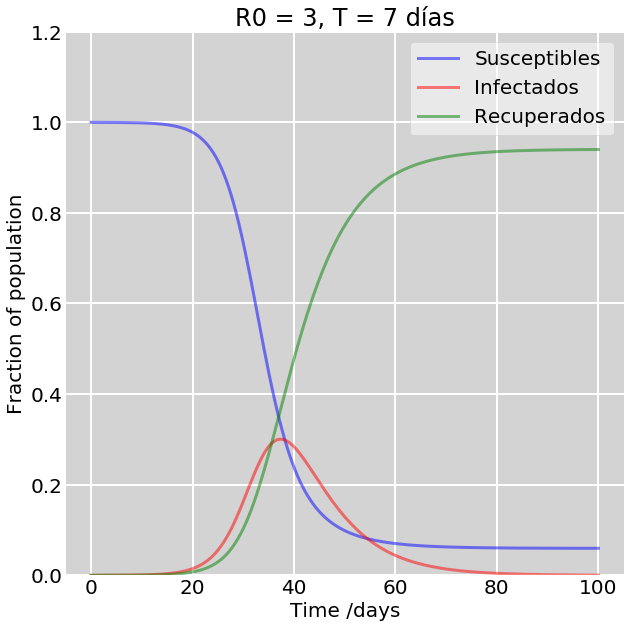

In [25]:
cplt.plot_sir(sirExample, "R0 = 3, T = 7 días")

In [26]:
ipeak = np.max(I) / N
print(f'fraction of infected in peak = {ipeak:.2f}')
rf = R[-1] / N
print(f'fraction of recovered (population who has suffered the desease and recovered or died) = {rf:.2f}')

fraction of infected in peak = 0.30
fraction of recovered (population who has suffered the desease and recovered or died) = 0.94


## An example of SIR prediction:

1. One can compute the population that will need to be hospitalised per CAA in different scenarios
2. Assume the total number of uci beds is 4404 (https://www.niusdiario.es/multimedia/nius-te-explica/colpaso-sistema-sanitario-espana-uci-unidad-cuidados-intensivos-hospitales-coronavirus_18_2914020237.html)
3. Assume fraction needs UCI is 5 % https://www.niusdiario.es/multimedia/nius-te-explica/colpaso-sistema-sanitario-espana-uci-unidad-cuidados-intensivos-hospitales-coronavirus_18_2914020237.html

## Data 22 March CCAA in Spain

In [27]:
path='/Users/jjgomezcadenas/Projects/Development/C19/data'
file = os.path.join(path,'PoblacionCAA2019.xlsx')
print(file)
dca = pd.read_excel(file) 
dca

/Users/jjgomezcadenas/Projects/Development/C19/data/PoblacionCAA2019.xlsx


,CCAA,2019
0,Andalucía,8414240
1,Aragón,1319291
2,Asturias,1022800
3,Baleares,1149460
4,Canarias,2153389
5,Cantabria,581078
6,Cas-León,2399548
7,Cas-Mancha,2032863
8,Cataluña,7675217
9,Valencia,5003769


In [243]:
def get_I_and_R_CAA(dca, N, I, R):
    In = I/N
    Icaa = [In * p for p in dca['2019'].values]
    Rn = R/N
    Rcaa = [Rn * p for p in dca['2019'].values]
    return Icaa, Rcaa

def uci_cases(IC, f_uci = 0.05):    
    return [I * f_uci for I in IC]

def uci_beds(dca, t_beds = 4404):
    tot = dca['2019'].sum()
    beds_capita = t_beds / tot
    print(f'Población total España ={tot:.2e}')
    beds = [beds_capita * p for p in dca['2019'].values]
    print(f'Beds UCI per CA = {beds}')
    return beds


In [29]:
ub = ut.uci_beds(dca)

Población total España =4.70e+07
Beds UCI per CA = [787.9927924445875, 123.55147929426927, 95.78512475426469, 107.64682195936359, 201.66467932094375, 54.4179005885399, 224.71744674799208, 190.37743064463118, 718.7833573142874, 468.60250088631426, 99.99094207213135, 252.80782996579268, 624.0262275878165, 139.9034085844217, 61.267080177929714, 206.75801680628808, 29.668103198965138, 7.93935815535031, 8.099499496110765]


In [30]:
IC, RC = ut.get_I_and_R_CAA(dca, N, I, R)
Iuci = ut.uci_cases(IC, f_uci = 0.05)

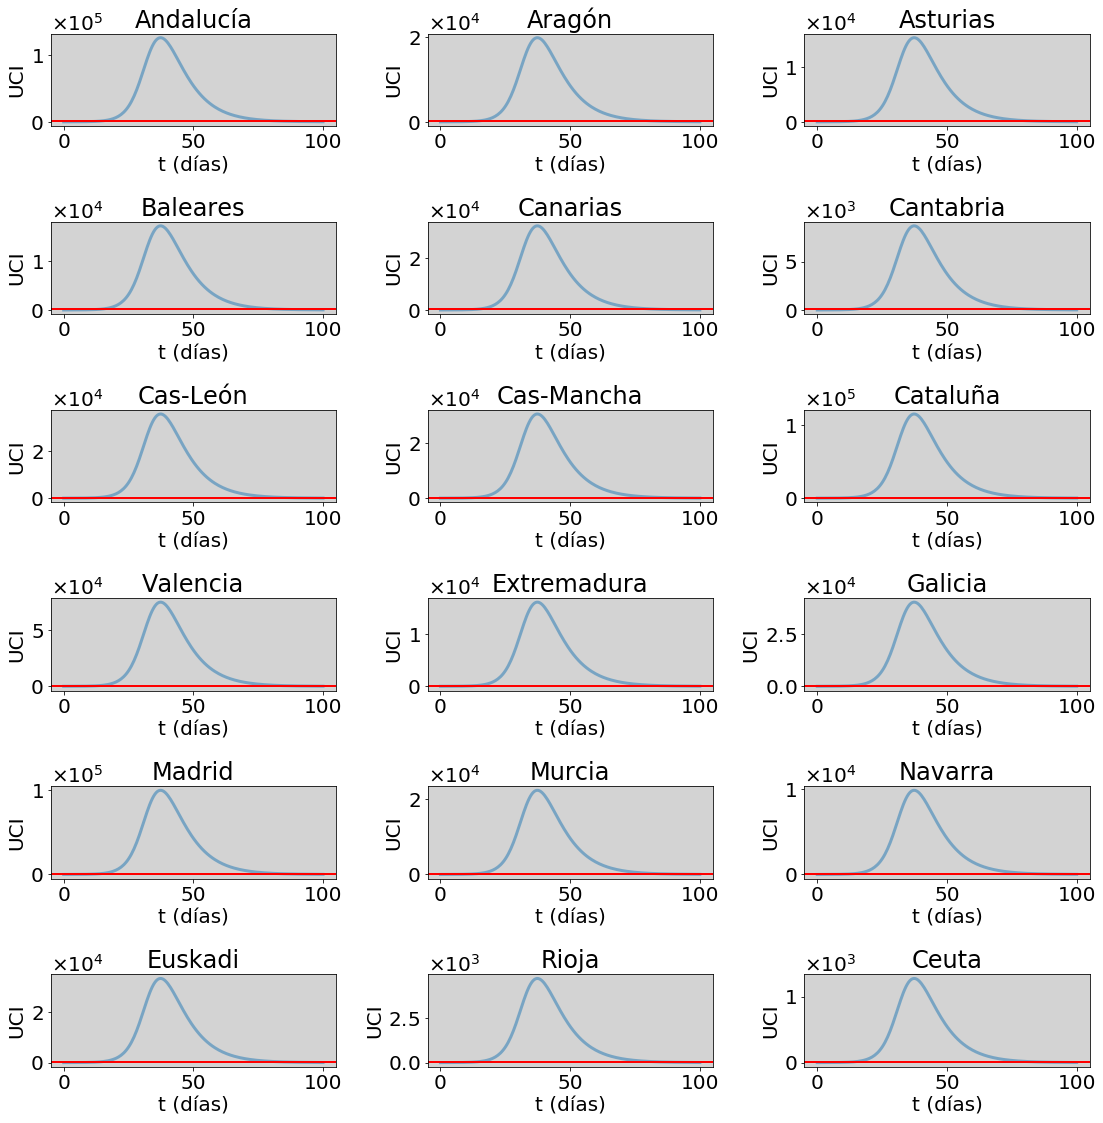

In [31]:
cplt.plot_ICAA(dca, ub, 
          t, Iuci, figsize=(16,16), facecolor='LightGrey')

## Solve for four cases. R0 = 1.3, 1.5, 1.8, 3.
## Time 7.5 days 

In [33]:
R0, Gamma = np.array([3, 1.8, 1.5, 1.3]), 1./7.5 
Beta = Gamma * R0
t = np.linspace(0, 150, 300)

# Total population, N.
N = 20000
# Initial number of infected and recovered individuals, I0 and R0.
i0, r0 = 1, 0
y0 = cbm.set_sir_initial_conditions(N, i0, r0)

t = np.linspace(0, 300, 300)

In [35]:
ret = [odeint(cbm.sir_deriv, y0, t, args=(N, beta, gamma)) for beta in Beta]
S0 = []
for r in ret:
    S, I, R = r.T
    S0.append(SIR(N, S, I, R, t, R0, beta, gamma))

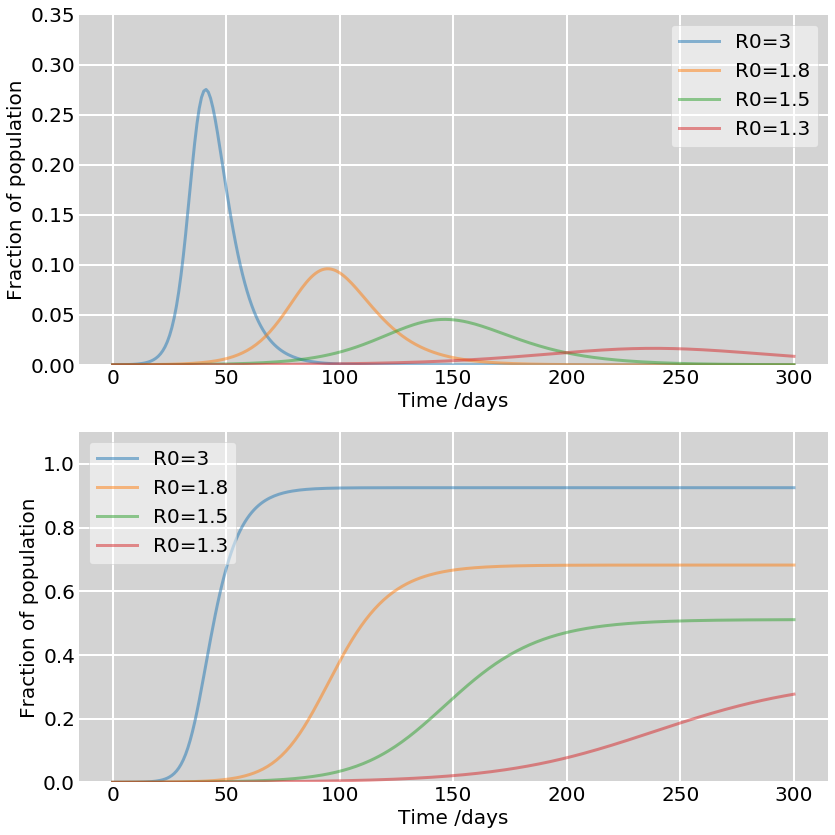

In [36]:
cplt.plot_sirs(S0,Ts=('R0=3','R0=1.8','R0=1.5','R0=1.3'), figsize=(12,12), lw=3, ylim=0.35)

In [38]:
IC1d8, _ =  ut.get_I_and_R_CAA(dca, N, S0[0].I, S0[0].R)
Iuci1d8  = ut.uci_cases(IC1d8, f_uci = 0.05)

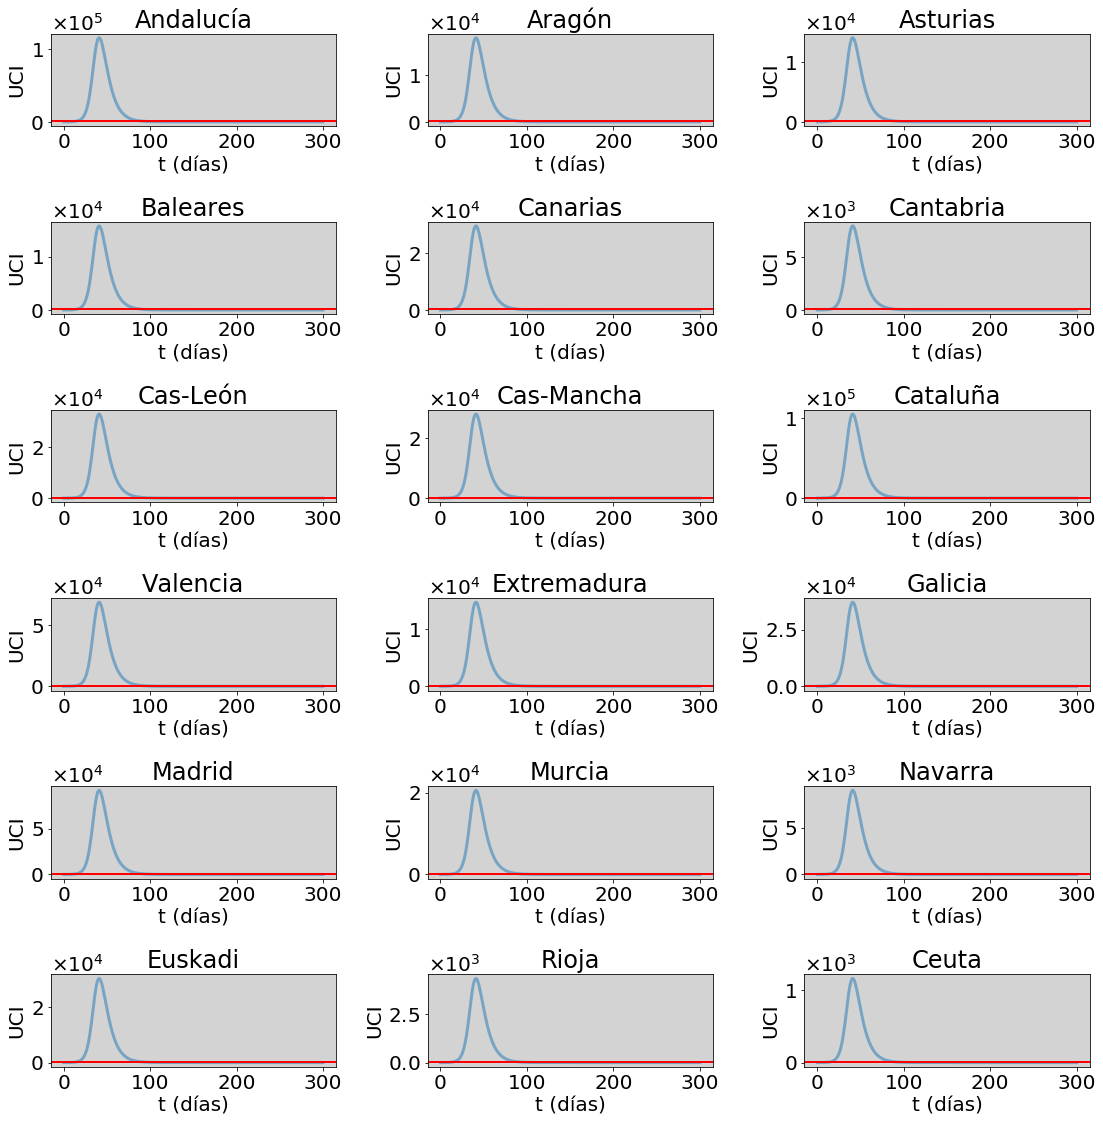

In [39]:
cplt.plot_ICAA(dca, ub, 
          t, Iuci1d8, figsize=(16,16), facecolor='LightGrey')

In [40]:
IC1d5, _ =  ut.get_I_and_R_CAA(dca, N, S0[1].I, S0[1].R)
Iuci1d5  = ut.uci_cases(IC1d5, f_uci = 0.05)

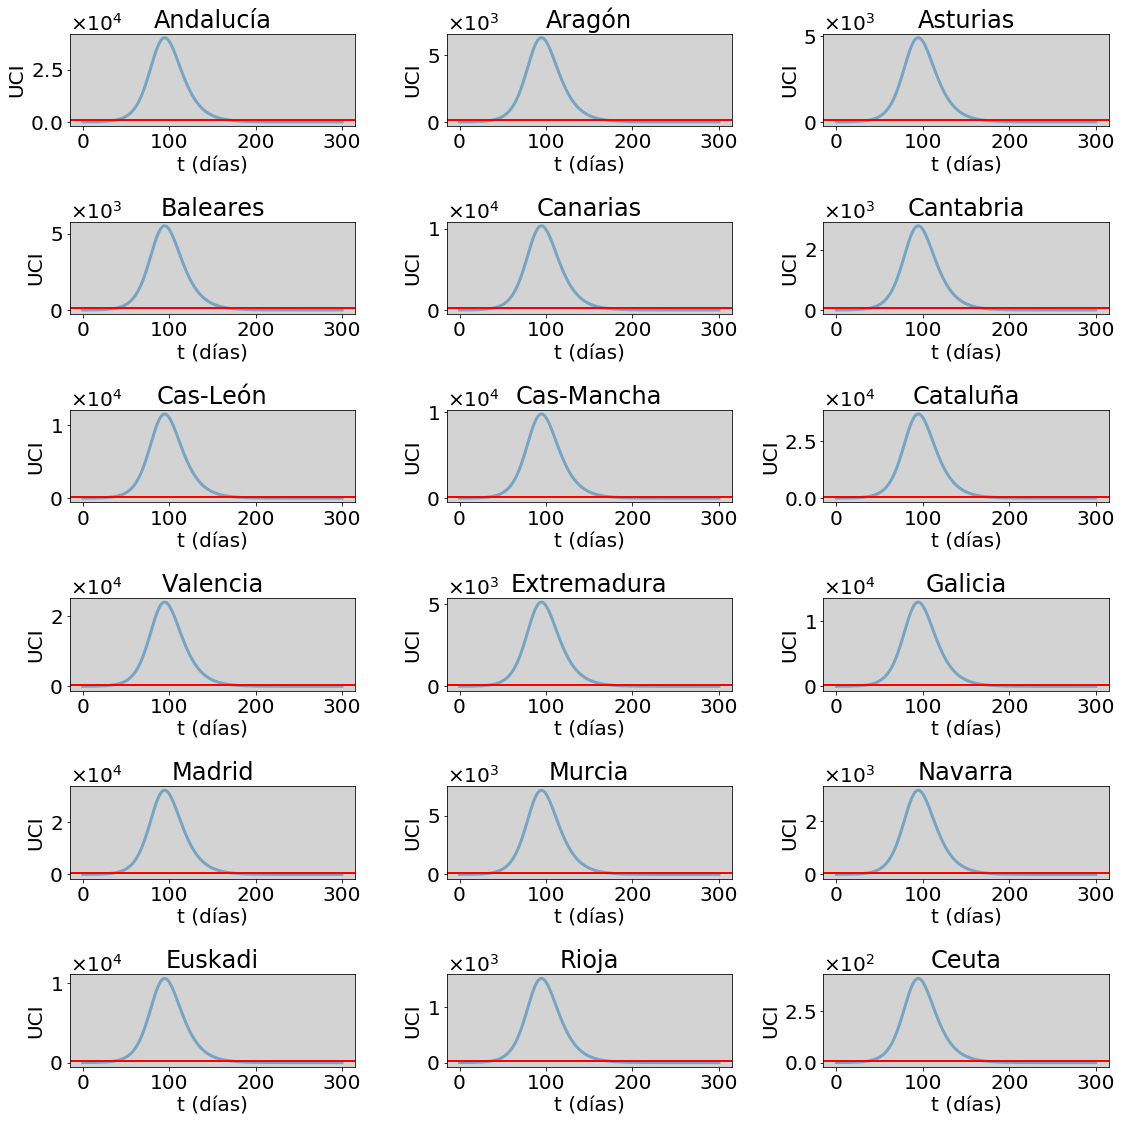

In [41]:
cplt.plot_ICAA(dca, ub, 
          t, Iuci1d5, figsize=(16,16), facecolor='LightGrey')

In [42]:
IC1d3, _ =  ut.get_I_and_R_CAA(dca, N, S0[2].I, S0[2].R)
Iuci1d3  = ut.uci_cases(IC1d3, f_uci = 0.05)

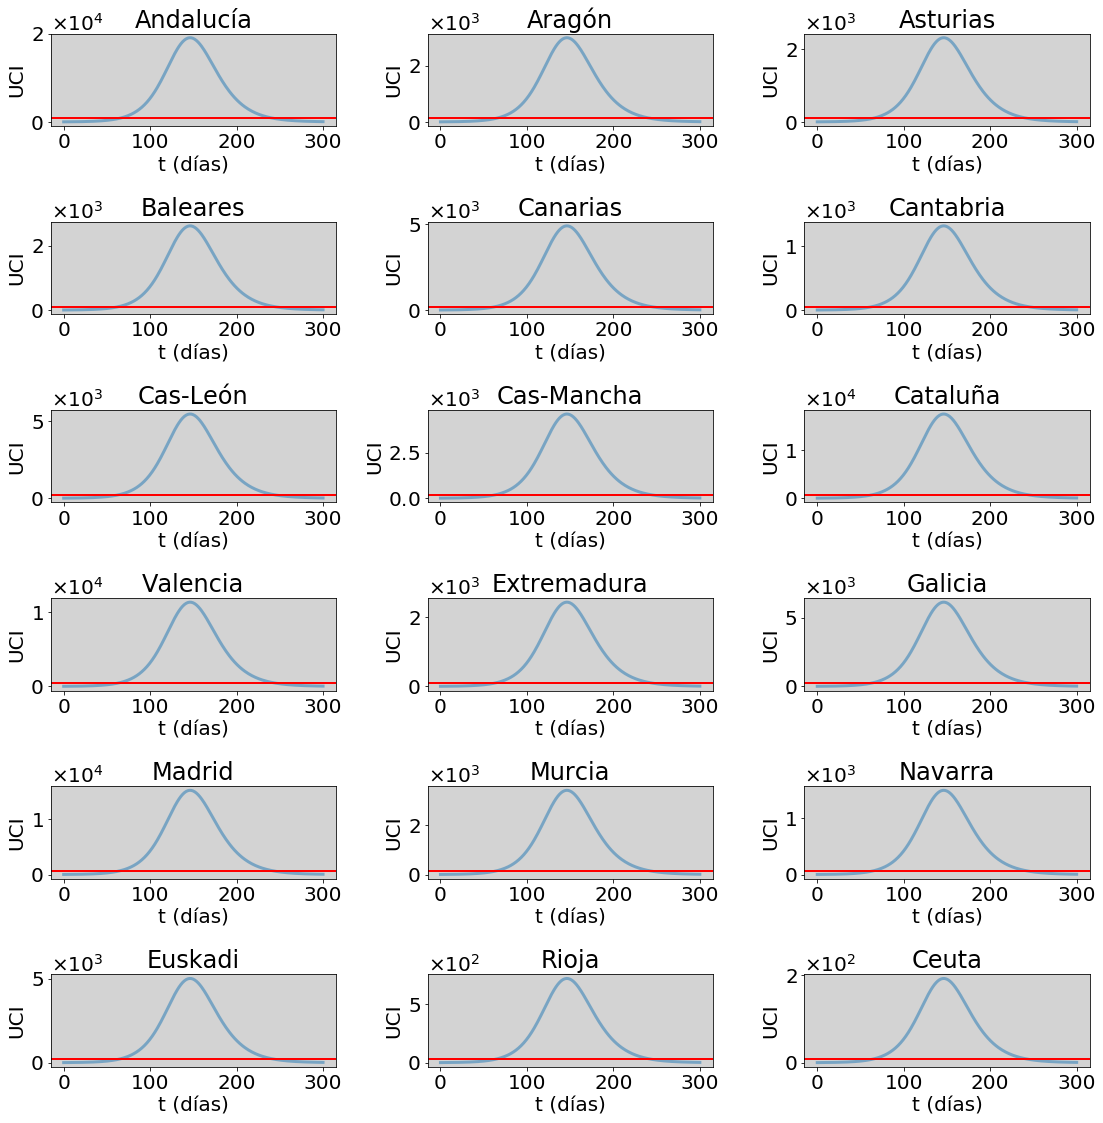

In [43]:
cplt.plot_ICAA(dca, ub, 
          t, Iuci1d3, figsize=(16,16), facecolor='LightGrey')

## Flattening the curve

In [44]:
R0, Gamma = np.array([1.3, 1.2, 1.1, 1.05]), 1./7.5 
Beta = Gamma * R0
t = np.linspace(0, 800, 800)

# Total population, N.
N = 10000
# Initial number of infected and recovered individuals, I0 and R0.
i0, r0 = 1, 0
y0 = cbm.set_sir_initial_conditions(N, i0, r0)


ret = [odeint(cbm.sir_deriv, y0, t, args=(N, beta, Gamma)) for beta in Beta]
S0 = []
for r in ret:
    S, I, R = r.T
    S0.append(SIR(N, S, I, R, t, R0, beta, gamma))

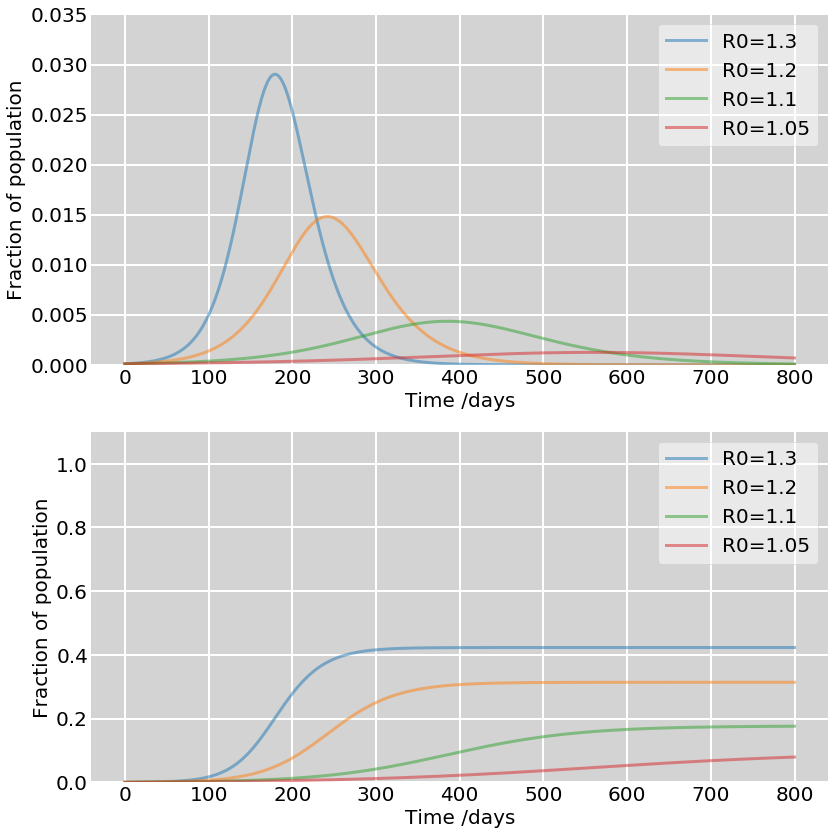

In [45]:
cplt.plot_sirs(S0,Ts=('R0=1.3','R0=1.2','R0=1.1','R0=1.05'), figsize=(12,12),lw=3, ylim=0.035)

In [46]:
IC1d2, _ =  ut.get_I_and_R_CAA(dca, N, S0[1].I, S0[1].R)
Iuci1d2  = ut.uci_cases(IC1d2, f_uci = 0.05)

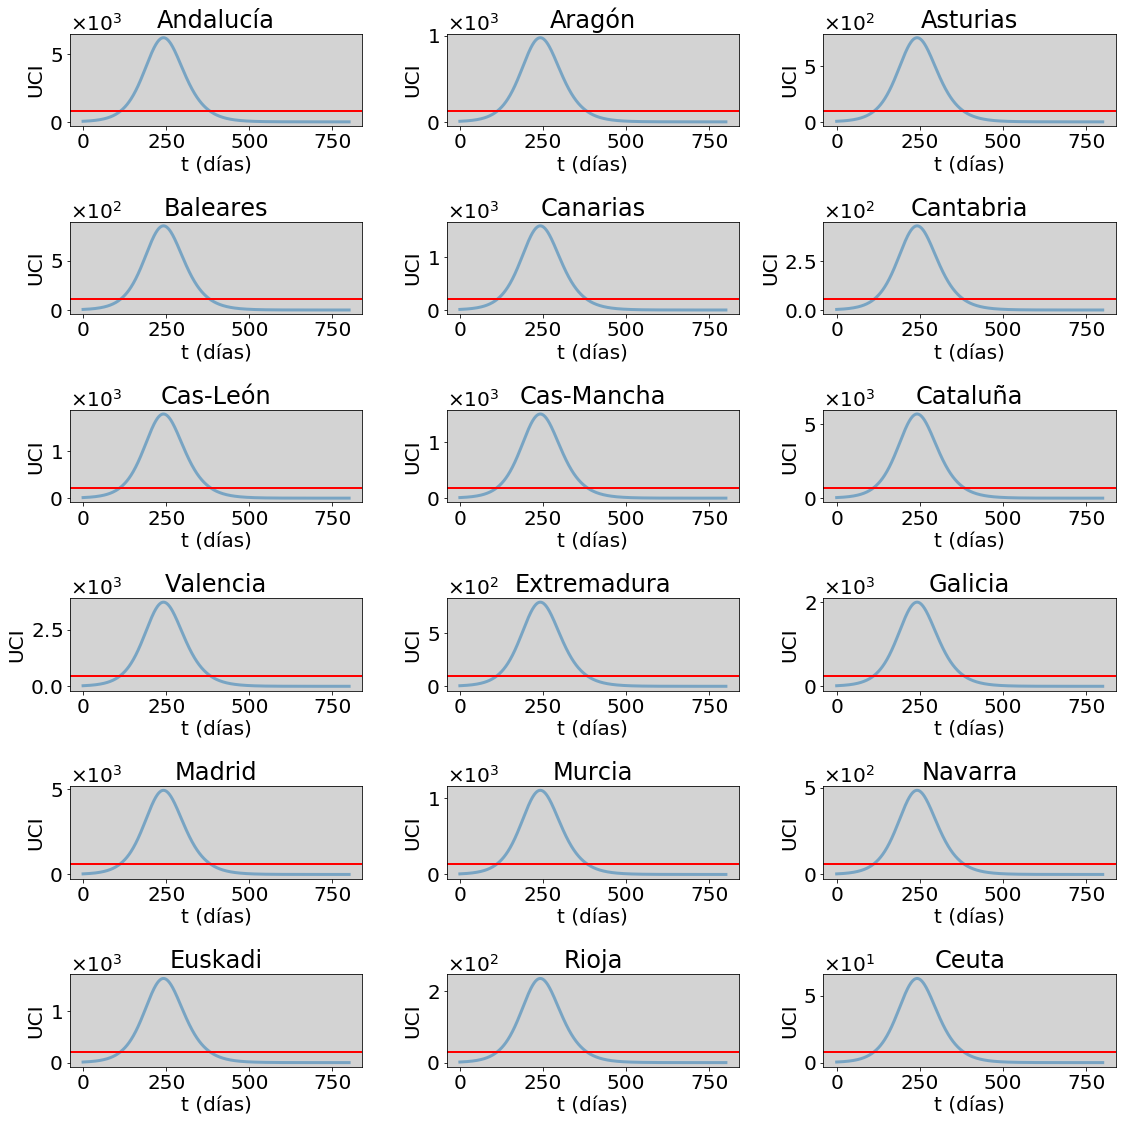

In [47]:
cplt.plot_ICAA(dca, ub, 
          t, Iuci1d2, figsize=(16,16), facecolor='LightGrey')

In [48]:
IC1d1, _ =  ut.get_I_and_R_CAA(dca, N, S0[2].I, S0[2].R)
Iuci1d1  = ut.uci_cases(IC1d1, f_uci = 0.05)

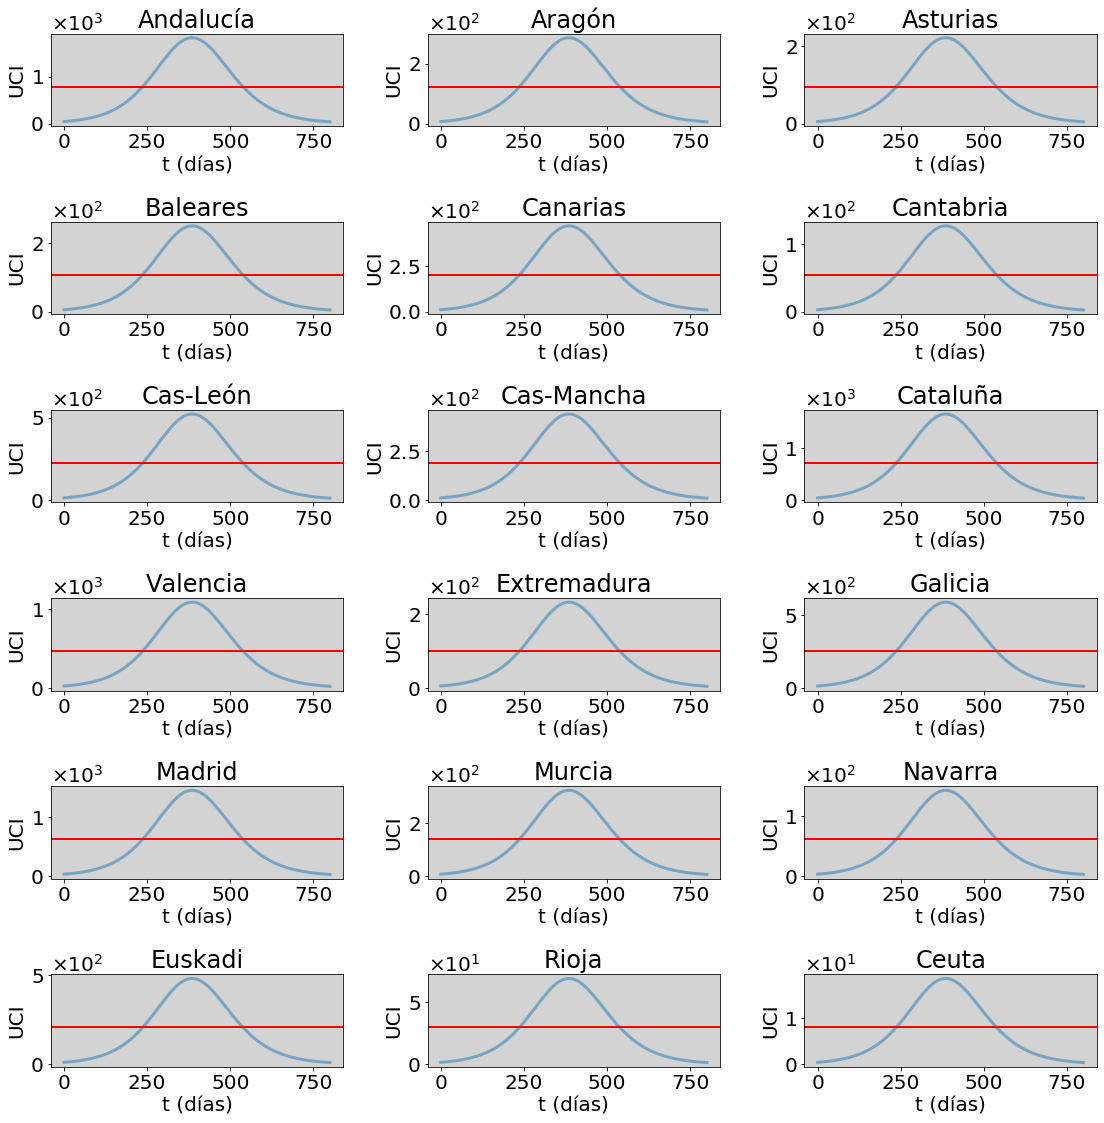

In [49]:
cplt.plot_ICAA(dca, ub, 
          t, Iuci1d1, figsize=(16,16), facecolor='LightGrey')

In [50]:
IC1d05, _ =  ut.get_I_and_R_CAA(dca, N, S0[3].I, S0[3].R)
Iuci1d05  = ut.uci_cases(IC1d05, f_uci = 0.05)

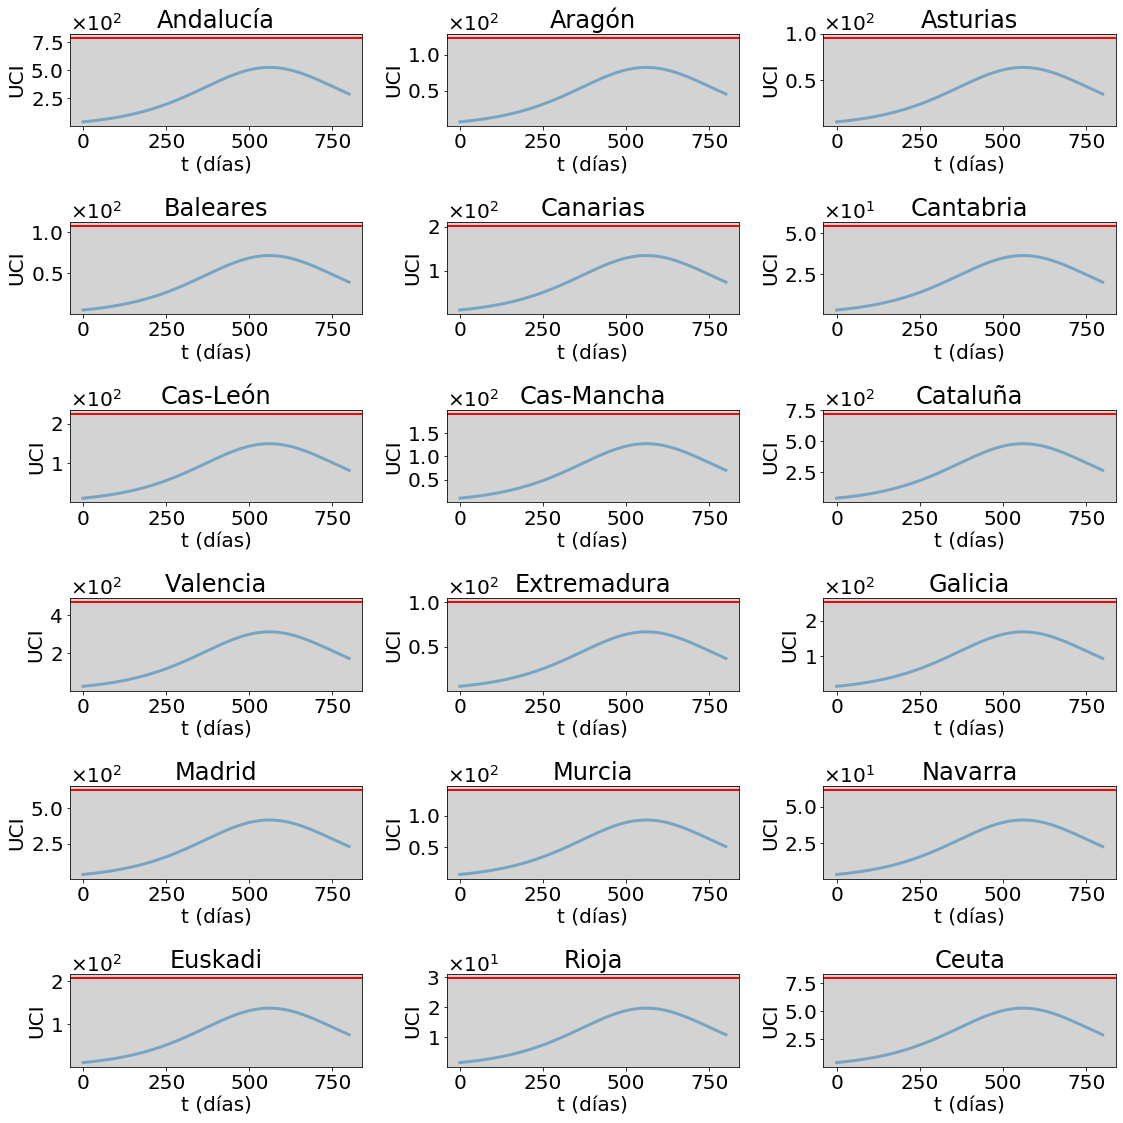

In [51]:
cplt.plot_ICAA(dca, ub, 
          t, Iuci1d05, figsize=(16,16), facecolor='LightGrey')

# SEIR


We now introduce a refinement to the SIR model which takes into account a latent period. The process of transmission often occurs due to an initial inoculation with a very small number of pathogen units (e.g., a few bacterial cells or virions). A period of time then ensues during which the pathogen reproduces rapidly within the host, relatively unchallenged by the immune system. During this stage, pathogen abundance is too low for active transmission to other susceptible hosts, and yet the pathogen is present. Hence, the host cannot be categorized as susceptible, infectious, or recovered; we need to introduce a new category for these individuals who are infected but not yet infectious. These individuals are referred to as Exposed and are represented by the variable E in SEIR models.

$$
\frac{dS}{dt} = - \beta S I \\
\frac{dE}{dt} = \beta S I - \sigma E \\
\frac{dI}{dt} = \sigma E - \gamma I \\
\frac{dR}{dt} = \gamma R
$$


In [52]:
N                = 1000
ND               = 400
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)


In [53]:
RES = odeint(cbm.seir_deriv, Y0, t_range, args=(Beta, Gamma, Sigma))
S, E, I = RES.T
R = 1 - S - E - I
seirE = SEIR(N = N, S=S, I=I, E=E, R=R, beta=Beta, R0=R0, gamma=Gamma, sigma = Sigma, t= t_range)

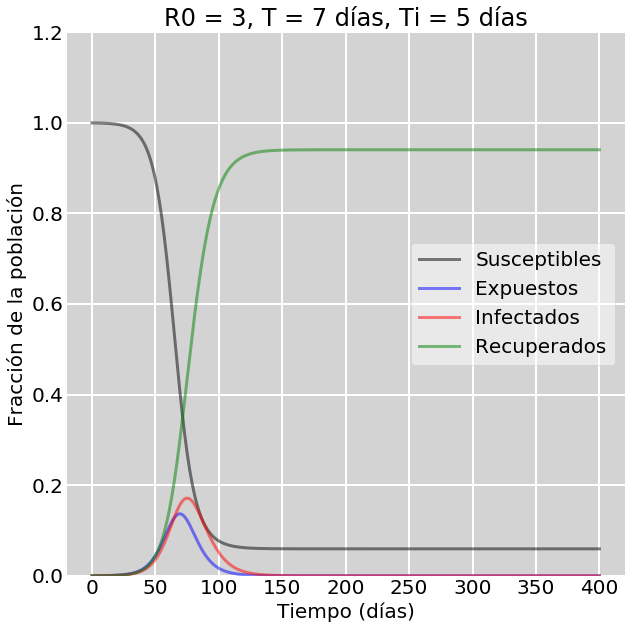

In [54]:
cplt.plot_seir(seirE, "R0 = 3, T = 7 días, Ti = 5 días")

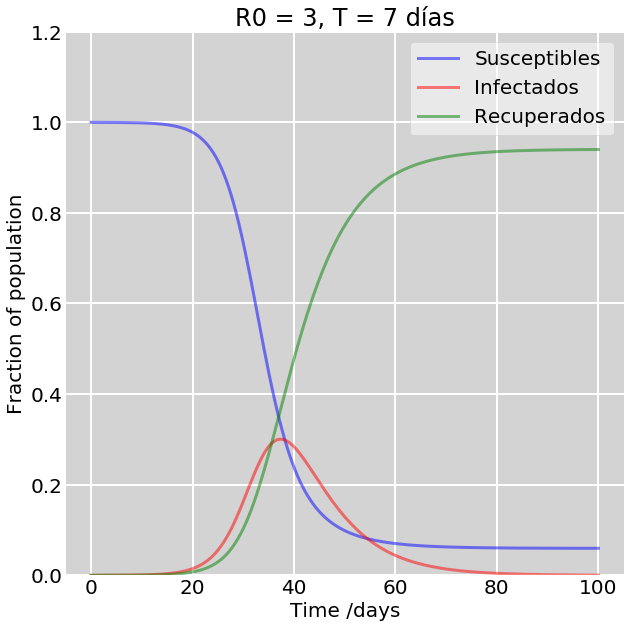

In [55]:
cplt.plot_sir(sirExample, "R0 = 3, T = 7 días")

## No mitigation

In [56]:

R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0

In [57]:
M = cbm.mitigation_function(t_range, ts = [(0, 400)], ms=[1])

In [58]:
RES = odeint(cbm.seir_deriv_time, Y0, t_range, args=(M, Beta, Gamma, Sigma))

In [59]:
S, E, I = RES.T
R = 1 - S - E - I
seirNoMit = SEIR(N = N, S=S, I=I, E=E, R=R, beta=Beta, R0=R0, gamma=Gamma, sigma = Sigma, t= t_range)

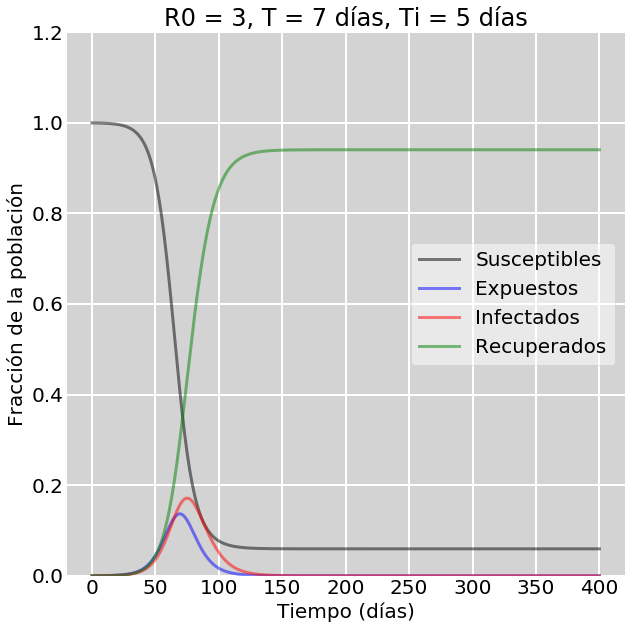

In [60]:
cplt.plot_seir(seirNoMit, "R0 = 3, T = 7 días, Ti = 5 días")

In [61]:
N                = 1000
ND               = 400
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)


In [45]:
def compute_seir(deriv_seir, Y0, Beta, Gamma, Sigma, t_range, ts = [(0, 400)], ms=[0.8]):
    def deriv_seir(y, t, beta, gamma, sigma):
        """Prepare differential equations for SEIR """
        S, E, I = y
        dSdt = -beta * M(t) * S * I 
        dEdt = beta * M(t) * S * I - sigma * E
        dIdt = sigma * E - gamma * I
        return dSdt, dEdt, dIdt
    
    C         = mitigation(t_range, ts, ms)
    M         = interp1d(t_range, C, bounds_error=False, fill_value="extrapolate")
    RES       = odeint(deriv_seir, Y0, t_range, args=(Beta, Gamma, Sigma))
    S, E, I   = RES.T
    R         = 1 - S - E - I
    seir      = SEIR(N = N, S=S, I=I, E=E, R=R, beta=Beta, R0=R0, gamma=Gamma, sigma = Sigma, t= t_range)
    return seir
    

## Early mitigation: soft (80%), hard (60%), xhard (40%)

### soft

In [65]:
seirEMits = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, ts = [(0, 400)], ms=[0.8])

###  hard

In [67]:
seirEMith = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, ts = [(0, 400)], ms=[0.6])

### xhard

In [68]:
seirEMitx = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, ts = [(0, 400)], ms=[0.4])

## Late mitigation

### soft

In [69]:
seirLMits = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range,
                         ts = [(0, 20), (20,400)], ms=[1, 0.8])

### hard

In [73]:
seirLMith = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range,
                         ts = [(0, 20), (20,400)], ms=[1, 0.6])

### very hard

In [71]:
seirLMitx = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range,
                         ts = [(0, 20), (20,400)], ms=[1, 0.4])

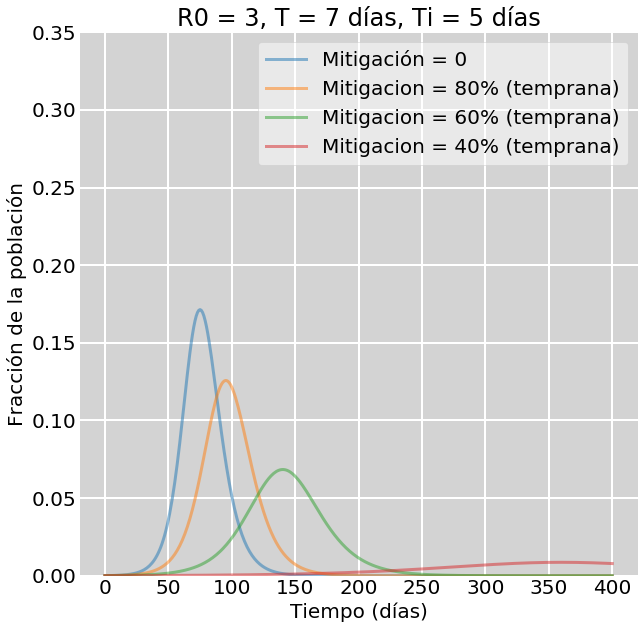

In [72]:
cplt.plot_Is([seirNoMit, seirEMits, seirEMith, seirEMitx], Ls = ['Mitigación = 0', 
                                                            'Mitigacion = 80% (temprana)', 
                                                            'Mitigacion = 60% (temprana)',
                                                            'Mitigacion = 40% (temprana)'], 
        T = "R0 = 3, T = 7 días, Ti = 5 días", 
        figsize=(10,10), facecolor='LightGrey')

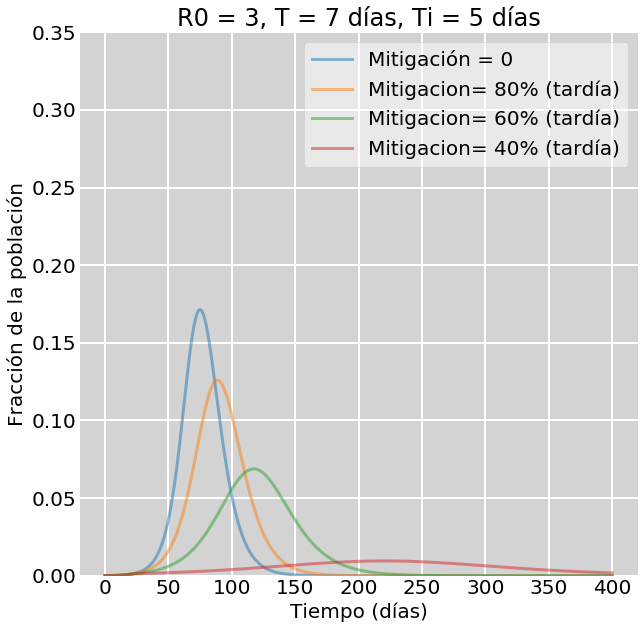

In [75]:
cplt.plot_Is([seirNoMit, seirLMits, seirLMith, seirLMitx], Ls = ['Mitigación = 0', 
                                                 'Mitigacion= 80% (tardía)', 
                                                 'Mitigacion= 60% (tardía)',
                                                 'Mitigacion= 40% (tardía)'], 
        T = "R0 = 3, T = 7 días, Ti = 5 días", 
        figsize=(10,10), facecolor='LightGrey')

## Early vs late

In [76]:
N                = 1000
ND               = 200
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)

In [77]:
seirNoMit = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, ts = [(0, 200)], ms=[1.0])
seirEMits = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, ts = [(0, 200)], ms=[0.8])
seirLMits = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                             ts = [(0, 20), (20,200)], ms=[1, 0.8])

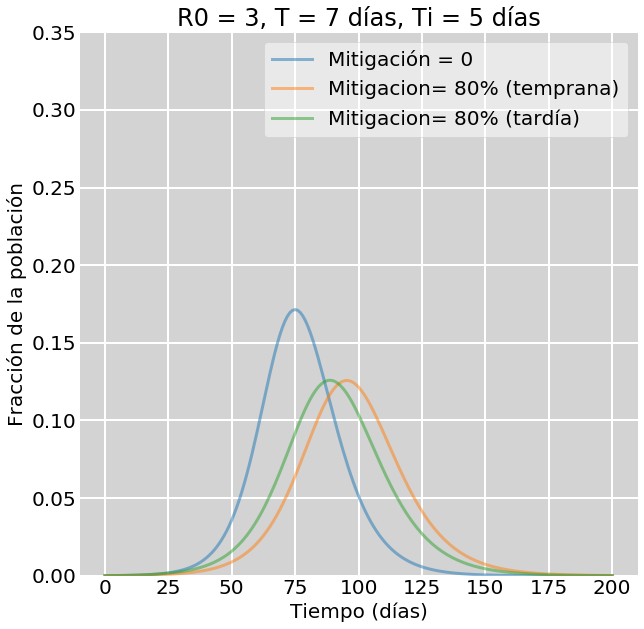

In [79]:
cplt.plot_Is([seirNoMit, seirEMits, seirLMits], Ls = ['Mitigación = 0', 
                                                 'Mitigacion= 80% (temprana)', 
                                                 'Mitigacion= 80% (tardía)',
                                                 ], 
        T = "R0 = 3, T = 7 días, Ti = 5 días", 
        figsize=(10,10), facecolor='LightGrey')

In [80]:
seirEMith = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, ts = [(0, 200)], ms=[0.6])
                            
seirLMith = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                             ts = [(0, 20), (20,200)], ms=[1, 0.6])

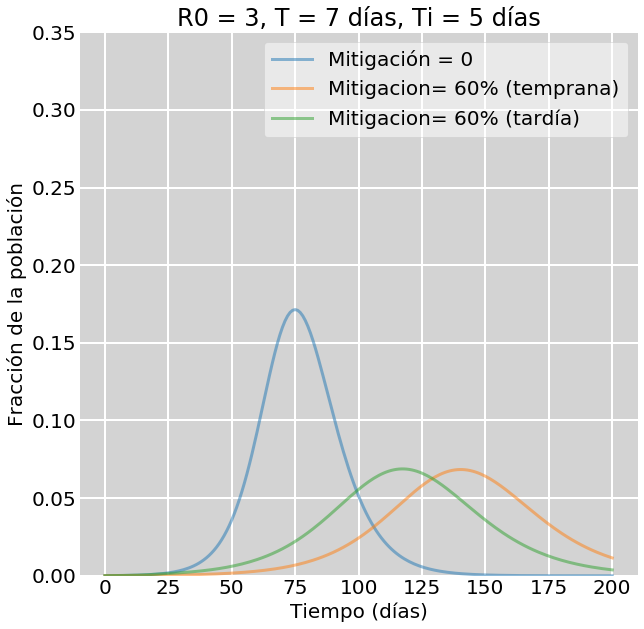

In [81]:
cplt.plot_Is([seirNoMit, seirEMith, seirLMith], Ls = ['Mitigación = 0', 
                                                 'Mitigacion= 60% (temprana)', 
                                                 'Mitigacion= 60% (tardía)',
                                                 ], 
        T = "R0 = 3, T = 7 días, Ti = 5 días", 
        figsize=(10,10), facecolor='LightGrey')

In [82]:
N                = 1000
ND               = 200
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)

In [83]:
seirI = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                         ts = [(0, 7), (8,15), (15, 200)], ms=[0.8, 0.6, 0.4])

In [84]:
seirR = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                         ts = [(0, 15), (15, 200)], ms=[1,  0.4])

In [85]:
seirNoMit = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, ts = [(0, 200)], ms=[1.0])

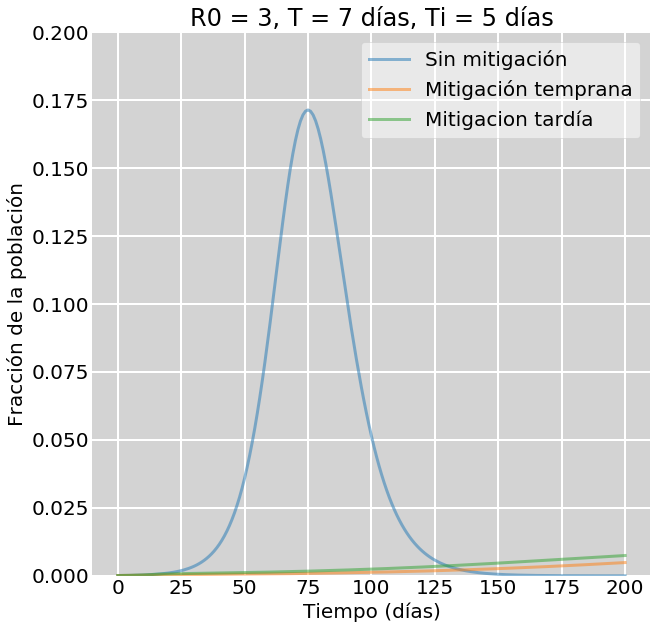

In [86]:
cplt.plot_Is([seirNoMit, seirI, seirR], Ls = ['Sin mitigación', 
                                         'Mitigación temprana', 
                                         'Mitigacion tardía',
                                                 ], 
        T = "R0 = 3, T = 7 días, Ti = 5 días", ylim=0.2,
        figsize=(10,10), facecolor='LightGrey')

In [101]:
N                = 1000
ND               = 400
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)

In [102]:
seirI = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                         ts = [(0, 7), (8,15), (15, 400)], ms=[0.8, 0.6, 0.4])

In [103]:
seirR = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                         ts = [(0, 15), (15, 400)], ms=[1,  0.4])

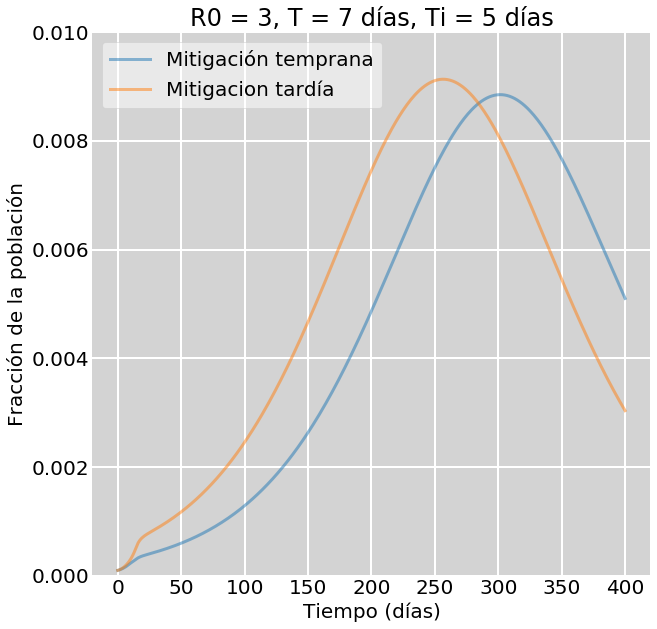

In [104]:
cplt.plot_Is([seirI, seirR], Ls = ['Mitigación temprana', 
                              'Mitigacion tardía',
                                                 ], 
        T = "R0 = 3, T = 7 días, Ti = 5 días", ylim= 0.01, 
        figsize=(10,10), facecolor='LightGrey')

In [91]:
N                = 1000
ND               = 40
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)

In [92]:
seirNoMit = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range,  ts = [(0, ND)], ms=[1.0])

In [93]:
seirMit80 = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range,  ts = [(0, ND)], ms=[0.8])

In [95]:
seirMit60 = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, ts = [(0, ND)], ms=[0.6])

In [96]:
seirMit40 = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range,  ts = [(0, ND)], ms=[0.4])

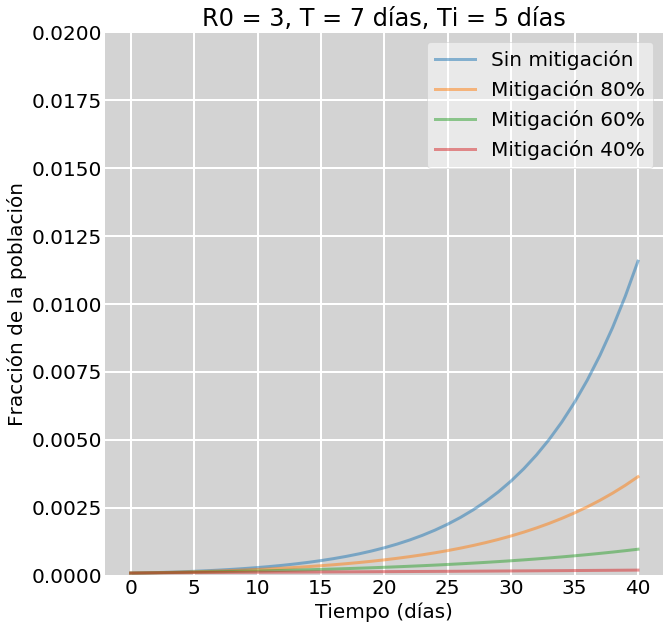

In [97]:
cplt.plot_Is([seirNoMit, seirMit80, seirMit60, seirMit40], Ls = ['Sin mitigación',
                                                            'Mitigación 80%',
                                                            'Mitigación 60%',
                                                            'Mitigación 40%'], 
        T = "R0 = 3, T = 7 días, Ti = 5 días", ylim= 0.02, 
        figsize=(10,10), facecolor='LightGrey')

## SIR and the beds

In [108]:
N                = 1000
ND               = 200
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)

In [116]:
seirR = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                         ts = [(0, 15), (15, ND)], ms=[1,  0.6])

In [117]:
IC, RC = ut.get_I_and_R_CAA(dca, seirR.N, seirR.I, seirR.R, norm=False)
Iur06 = ut.uci_cases(IC, f_uci = 0.05)

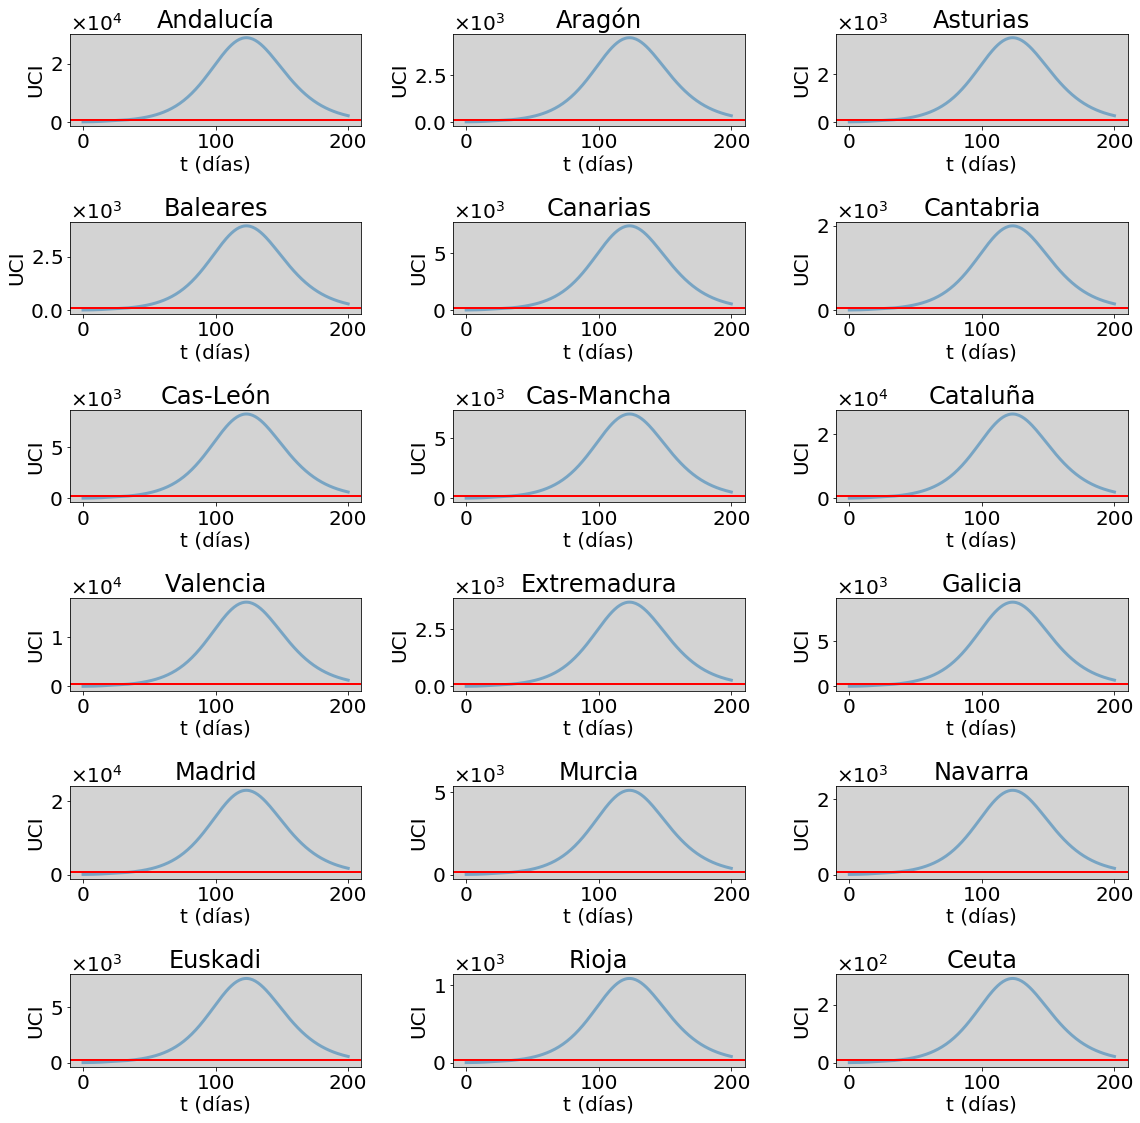

In [118]:
cplt.plot_ICAA(dca, ub, 
          t_range, Iur06, figsize=(16,16), facecolor='LightGrey')

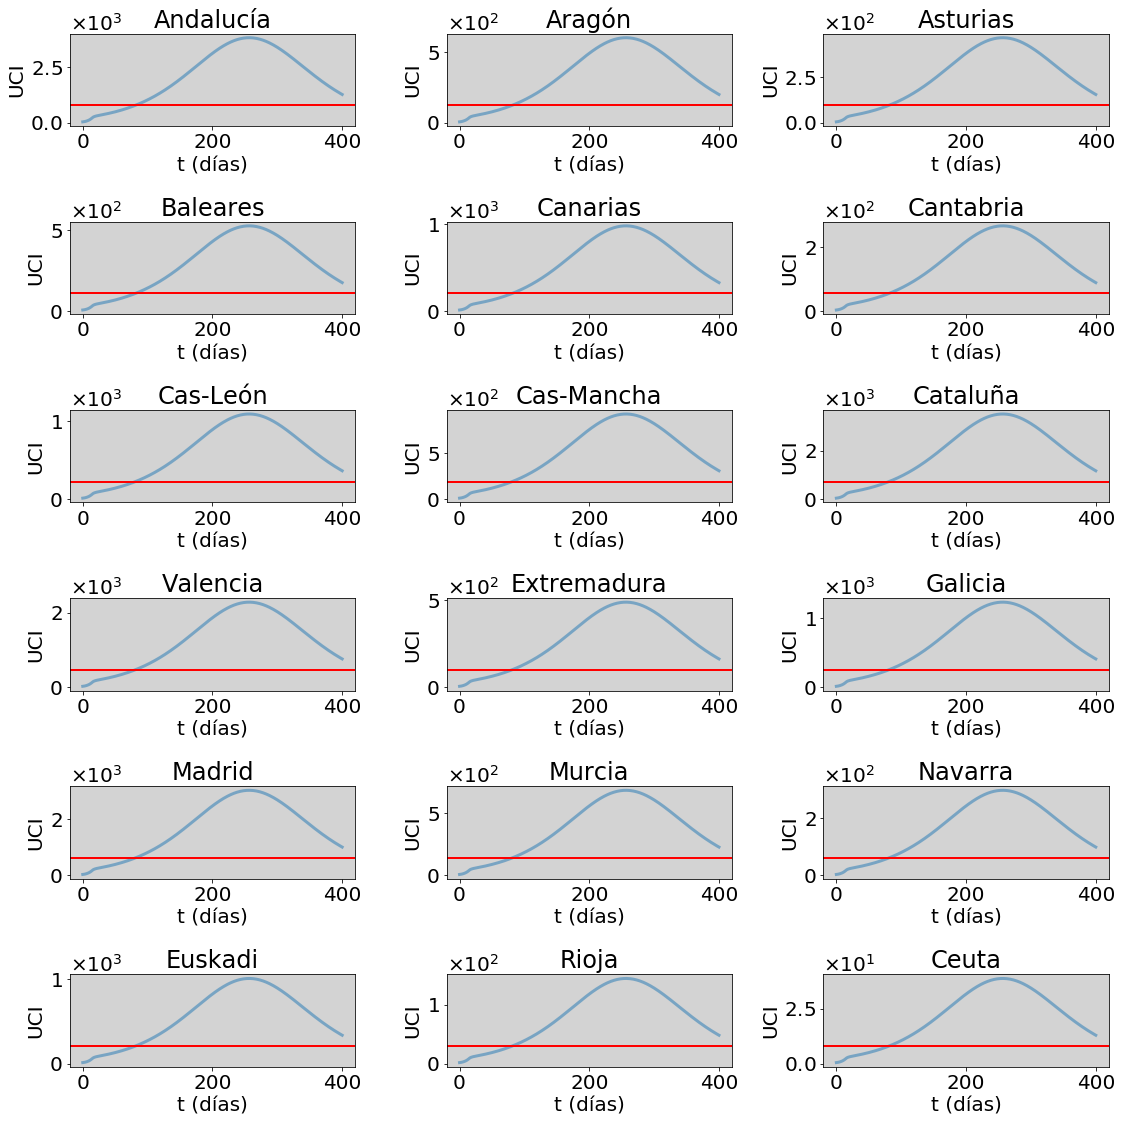

In [120]:
N                = 1000
ND               = 400
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)

seirR = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                         ts = [(0, 15), (15, ND)], ms=[1,  0.4])
IC, RC = ut.get_I_and_R_CAA(dca, seirR.N, seirR.I, seirR.R, norm=False)
Iur04 = ut.uci_cases(IC, f_uci = 0.05)
cplt.plot_ICAA(dca, ub, 
          t_range, Iur04, figsize=(16,16), facecolor='LightGrey')

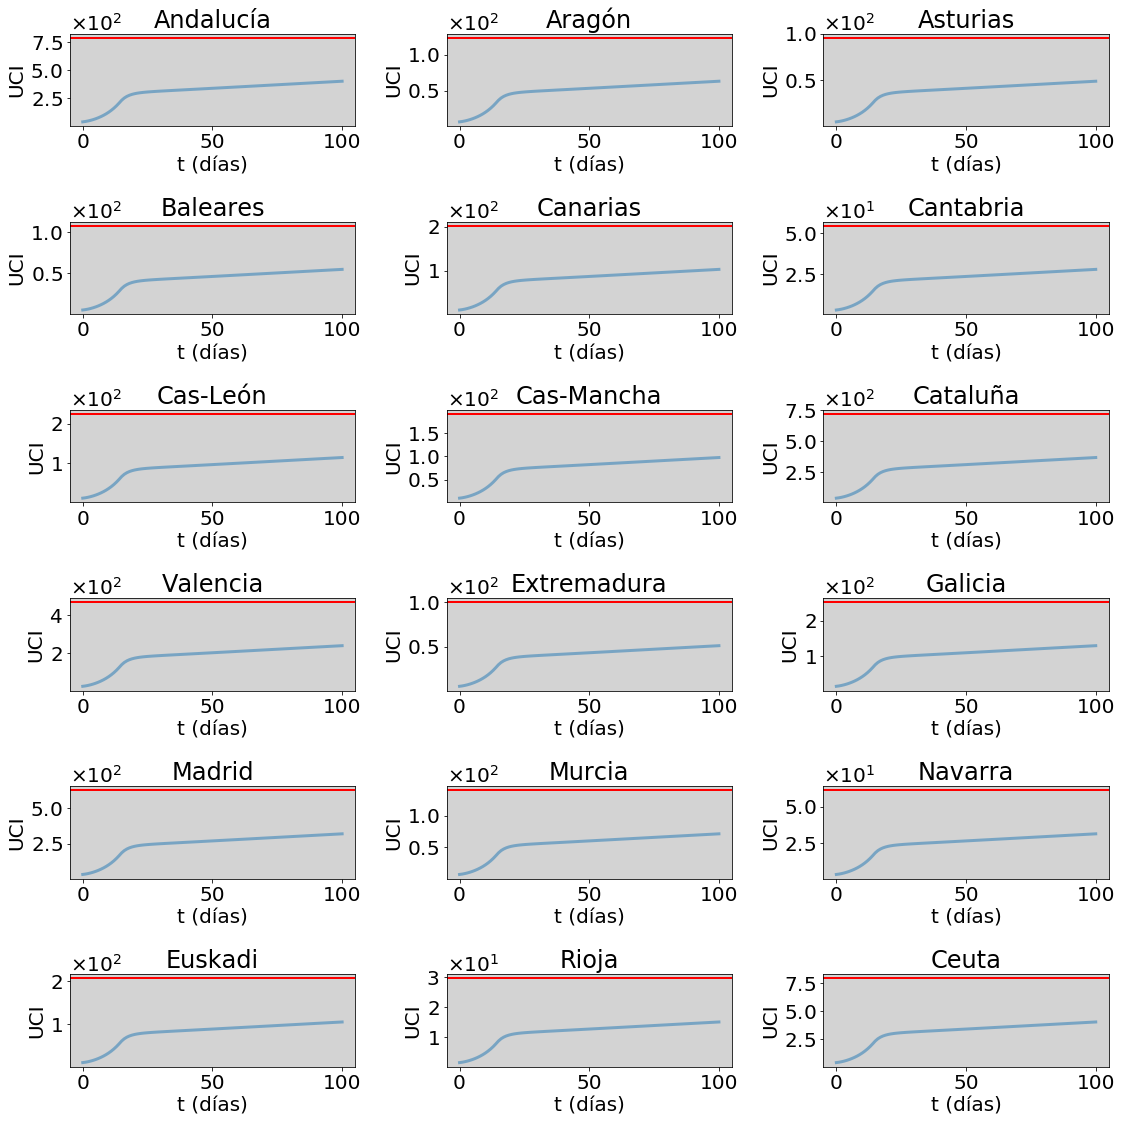

In [126]:
N                = 1000
ND               = 100
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
R0, Gamma, Sigma = 3, 1./7, 1./5. 
Beta             = Gamma * R0
I0, E0           = 1E-4, 1E-4
S0               = 1 - I0 - E0
Y0               = (S0, E0, I0)

seirR = cbm.compute_seir(N, Y0, R0, Gamma, Sigma, t_range, 
                         ts = [(0, 15), (15, ND)], ms=[1,  0.35])
IC, RC = ut.get_I_and_R_CAA(dca, seirR.N, seirR.I, seirR.R, norm=False)
Iur04 = ut.uci_cases(IC, f_uci = 0.05)
cplt.plot_ICAA(dca, ub, 
          t_range, Iur04, figsize=(16,16), facecolor='LightGrey')

In [138]:
3434 /47610

0.07212770426381013

In [131]:
0.58 * 17.85

10.353

In [135]:
17.85 / 13.5

1.3222222222222224

In [136]:
5476 / 59138

0.09259697656329263

In [137]:
281 / 5683

0.049445715291219425

In [139]:
1720 / 28572

0.060198796024079515

In [141]:
7.2 / 1.38

5.217391304347827

In [143]:
1/47

0.02127659574468085

In [145]:
123000 + 55000

178000